# aia_stereo_loop.ipynb

This notebook serves to generate a comparative image between AIA and SDO images, and overlay a generated / selected set of CLB coordinates concursively.

- Ensure that **FITS_DIR** points to a directory containing files from AIA or STEREO instruments.
- Ensure that **PARAMS_PATH** points to a pickled file that is either a dictionary containing CLB parameters or is a nested dictionary containing a dictionary of CLB parameters
- Change **nested_params** to True/False depending on the structure of your pickled CLB parameters
    - Alternatively, specify CLB parameters manually by setting **manual_params** to TRUE and specifying the following in **man_loop_params**
        - **majax** : major axis (Mm)
        - **minax** : minor axis (Mm)
        - **radius** : radius (overrided by majax and minax if ellipse = True in CLB call) (Mm)
        - **height** : height of center of loop above solar surface (Mm)
        - **phi0**: heliographic latitude (degrees)
        - **theta0**: heliographic longitude (degrees)
        - **el**: elevation angle relative to surface of sun (degrees)
        - **az**: azimuth angle relative to central pole (degrees)
        - **samples_num**: resolution of generated loop (number of points)

In [22]:
from sunpy.net import Fido, attrs as a
import sunpy.data.sample

from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const

from ipywidgets import *

from CoronalLoopBuilder.builder import CoronalLoopBuilder # type: ignore
from rushlight.utils.proj_imag_classified import SyntheticFilterImage as sfi
from rushlight.config import config

import matplotlib
# %matplotlib qt5
# %matplotlib notebook
# %matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

import aiastereo as aist

In [23]:
# Settings for the following run
use_fido = False            # Download new AIA / SDO images using sunpy.net

nested_params = False       # Using PARAMS_PATH .pkl file with nested dictionary structure
manual_params = False       # OVERRIDES NESTED PARAMS to use manually defined loop params
save_synthobj = False       # Save SyntheticFilterImage object metadata to file
update_loop = False         # Save loop_params if changing using sliders
default_crop = False        # Automatically crop aia/sdo image within range of CLB coordinate

available_wavelengths = [171, 193, 304]
target_wavelength = available_wavelengths[1]     # Wavelength to be plotted
ellipse = False             # Is the fitted loop an ellipse?
c = 'r'                     # Color of the produced clb loop
p = 50                      # Percentile for STEREO contour

sliders = False             # Display matplotlib figure with interactive sliders for loop parameters
inline = False              # Display matplotlib figure inline with notebook

In [24]:
# Change these depending on location of target files

# Directory containing fits files from AIA and STEREO
if use_fido:
    FITS_DIR = None
else:    
    FITS_DIR = './observations/'

# .pkl file containing CLB parameters for loop orientation
if nested_params:
    PARAMS_PATH =  '/home/gabriel/rad_transfer_/tests/sab_tests/testing_files/loop_params/view_param.pickle'
else:
    PARAMS_PATH = './loop_params/AIA_STEREO_195_circular_back.pkl'

if manual_params:           # Define the CLB parameters manually https://github.com/sageyu123/CoronalLoopBuilder
    loop_params = {
        "majax": 38 * u.Mm,
        "minax": 54 * u.Mm,
        "radius": 10 * u.Mm,
        "height": 16.0 * u.Mm,
        "phi0": 95.0 * u.deg,
        "theta0": -14.60 * u.deg,
        "el": 90.0 * u.deg,
        "az": 152.0 * u.deg,
        "samples_num": 100
    }


## PARAMS_PATH Parsing
Ensuring the structure of the provided pickle parameters will be compatible with CLB

In [25]:
# If the provided params path points to a nested dictionary, unpack those values.
if not manual_params:
  try:
    with open(PARAMS_PATH, 'rb') as f:
      data = pickle.load(f)
      data['phi0']
      loop_params = data
      f.close()
    print('Params path points to loop params - proceeding.')
    print(loop_params)
  except:
    nested_params = True
    print('Params path points to nested dictionary. Extracting loop_params...')
    loop_params_dict = aist.extract_loop_params(PARAMS_PATH)
    print(loop_params_dict.keys())


Params path points to loop params - proceeding.
{'radius': <Quantity 40. Mm>, 'height': <Quantity 30. Mm>, 'phi0': <Quantity 93. deg>, 'theta0': <Quantity -14. deg>, 'el': <Quantity 90. deg>, 'az': <Quantity 0. deg>, 'samples_num': 100}


In [26]:
# If the provided params path points to a nested dictionary, select one of the loop_parameters for display.
if nested_params:  
  year = 2012
  hour = 8

  loop_params = aist.select_param_year(loop_params_dict, year, hour)
  
  print(loop_params)


# Collecting aia and sdo images

Use Sunpy Fido to acquire aia and sdo images for comparison. Set **FITS_DIR** = None at the top of this file to access this. Can search for multiple wavelengths simultaneously. Searches first for stereo data as its cadence is usually longer than aia. If only 1 stereo image is found, aia images can be found in a time region around the stereo image. Images will be saved to './observations/' unless **FITS_DIR** is set otherwise below.

In [27]:
debug = False
# Only asks for images if fits directory is not defined
if not FITS_DIR:
  # Sets a time range
  while True:
    try:
      if debug:
        start_time = "2012-07-19T10:00"
        end_time = "2012-07-19T11:00"
      else:
        # Prompt user for desired time range
        # Example: 2012-07-19T10:00, 2012-07-19T11:00
        start_time = aist.get_user_input("Enter the start time (eg. 2012-07-19T10:00): ")
        end_time = aist.get_user_input("Enter the end time (eg. 2012-07-19T11:00): ")

      # Convert user input to Fido.Time objects
      time = a.Time(start_time, end_time)
      break
    except:
      if start_time == 'exit': sys.exit(1)
      print('Time range not valid. Try again!')

  # Sets the target wavelengths
  while True:
    try:
      if debug:
        wavelengths = '171'
      else:
        # Prompt user to select desired AIA wavelengths (comma separated)
        wavelengths = aist.get_user_input("Enter comma-separated AIA wavelengths eg. 171, 195, 304 (Angstroms): ")
      
      wavs = [a.Wavelength(float(wav)*u.angstrom) for wav in wavelengths.split(",")]
      break
    except:
      if wavelengths == 'exit': sys.exit(1)
      print('Wavelength selection not valid. Try again!')

  # Containers for later retrieval of results
  aia_results = []
  stereo_results = []

  # Search for one wavelength at a time to ensure match
  for wav in wavs:
    print(f"For {wav.max.value} band\n")

    aia_wav = wav
    stereo_wav = wav

    # If the wavelength is 195, search for 193 instead
    if stereo_wav == a.Wavelength(float(193)*u.angstrom):
      stereo_wav = a.Wavelength(float(195)*u.angstrom)

    # Search for STEREO data first
    stereo_result = Fido.search(time, a.Instrument.secchi, a.Sample(1*u.minute), a.Physobs('Intensity'), stereo_wav)
    print("STEREO results:")
    print(stereo_result.show('Start Time', 'End Time', 'Source'))
    
    n_stereo = stereo_result.__dict__['_numfile']

    # If STEREO results are found, search for AIA data within that timeframe
    if n_stereo == 1:
      aia_result = aist.approx_stereo(stereo_result, aia_wav)
    elif n_stereo > 1:
      time = a.Time(stereo_result[0, 0]["Start Time"], stereo_result[-1, 0]["End Time"])
      aia_result = Fido.search(time, a.Instrument.aia, a.Sample(1*u.minute), a.Physobs('Intensity'), aia_wav)
      print("AIA results within STEREO timeframe:")
      print(aia_result.show('Start Time', 'End Time', 'Source'))
      n_aia = aia_result.__dict__['_numfile']
      if n_aia == 0:
        aia_result = aist.approx_stereo(stereo_result, aia_wav)
    else:
      print("No STEREO results found in the specified timeframe.")

    # Saves the results for next cell
    stereo_results.append(stereo_result)
    aia_results.append(aia_result)

    # Saves the results to local .txt file for easy viewing (notebook may truncate output)
    directory_path = 'fido_results/'
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    file = open(f'{directory_path}{start_time}_{end_time}_{wav.max.value}.txt', 'w')
    file.write(str(stereo_result))
    file.write(str(aia_result))
    file.close()
    

In [28]:
# Allows the user to select which searched event to download

debug = False
if not FITS_DIR:
  FITS_DIR = './observations/' # <-- Change this if you would like a custom download location
  directory_path = FITS_DIR
  if not os.path.exists(directory_path):
    os.makedirs(directory_path)

  for w, wav in enumerate(wavs):
      while True:
        try:
          if debug:
            aia_selection = '-1'
            stereo_selection = '-1'
          else:
            # Allow user to select results to download
            aia_selection = aist.get_user_input("Enter the index of the AIA result to download (or -1 to skip): ")
            stereo_selection = aist.get_user_input("Enter the index of the STEREO result to download (or -1 to skip): ")

          if int(aia_selection) > -1:
            aia_sel = aia_results[w][0, int(aia_selection)]
            download = Fido.fetch(aia_sel, path=FITS_DIR)
            print("Download errors (AIA):", download.errors)

          # Download selected STEREO data
          if int(stereo_selection) > -1:
            stereo_sel = stereo_results[w][0, int(stereo_selection)]
            download = Fido.fetch(stereo_sel, path=FITS_DIR)
            print("Download errors (STEREO):", download.errors)

          break
        except:
          if aia_selection == 'exit': sys.exit(1)
          print('Selection not valid. Try again!')


## Pairing aia and sdo images

Ensure that the images used in this procedure are of the same filter wavelength

- Change **target_wavelength** to be the filter wavelength of the two images you would like to compare.

In [29]:
# Finds pairs of FITS files with different instruments but equal filter wavelengths
matching_pairs = aist.find_matching_fits(FITS_DIR)

for pair in matching_pairs:
  print(f"Matching pair: {pair[0]}, {pair[1]}") 

Matching pair: ./observations/aia_lev1_171a_2012_07_19t10_14_11_34z_image_lev1.fits, ./observations/20120719_101400_n4eua.fts
Matching pair: ./observations/aia.lev1.304A_2012-07-19T10_36_19.12Z.image_lev1.fits, ./observations/20120719_103615_n4euA.fts
Matching pair: ./observations/aia.lev1.193A_2012-07-19T10_40_30.84Z.image_lev1.fits, ./observations/20120719_104030_n4euA.fts


In [30]:
# Select select wavelength for matching pair
pair = aist.select_pair_by_wavelength(matching_pairs, target_wavelength)
print(pair)

('./observations/aia.lev1.193A_2012-07-19T10_40_30.84Z.image_lev1.fits', './observations/20120719_104030_n4euA.fts')


In [31]:
# Assign AIA and STEREO maps to those loaded from the FITS files

pair_maps = [sunpy.map.Map(item) for item in pair]

# Load AIA and SDO maps
aia_map = None
stereo_map = None
for m in pair_maps:
    if m.meta['TELESCOP'] == 'SDO/AIA':
        aia_map = m
    elif m.meta['TELESCOP'] == 'STEREO':
        stereo_map = m
    else:
        print('Pair contains maps from non AIA / STEREO instruments')

# Final check
print(aia_map.instrument, aia_map.wavelength, stereo_map.instrument, stereo_map.wavelength)


AIA 2 193.0 Angstrom SECCHI 195.0 Angstrom


## Crop to ROI

Crop both maps to the preferred ROI. This is done through SkyCoord, and specifying bottom left and top right coordinates.

- Change the values in **aia_crop_lims** and **stereo_crop_lims** to match the coordinates for the following in ARCSECONDS
    - **blox**: Bottom Left corner, x-coordinate
    - **bloy**: Bottom Left corner, y-coordinate
    - **trox**: Top Right corner, x-coordinate
    - **troy**: Top Left corner, y-coordinate
- Alternatively, set **default_crop** = True and adjust **window** to change amount of image visible around CLB foot midpoint

In [32]:
aia_crop_lims = {
    'blox': 800,
    'bloy': -400,
    'trox': 1100,
    'troy': -100,
}

stereo_crop_lims = {
    'blox': -650,
    'bloy': -450,
    'trox': -350,
    'troy': -150,
}

# Set default crop limits
if default_crop:
    center = (loop_params['phi0'], loop_params['theta0'])
        
    center_aia = SkyCoord(lon=center[0], lat=center[1], radius=const.R_sun, 
                        frame='heliographic_stonyhurst',
                        observer=aia_map.observer_coordinate, obstime=aia_map.coordinate_frame.obstime) \
                        .transform_to(frame='helioprojective')

    center_stereo = SkyCoord(lon=center[0], lat=center[1], radius=const.R_sun, 
                            frame='heliographic_stonyhurst',
                            observer=stereo_map.observer_coordinate, obstime=aia_map.coordinate_frame.obstime) \
                            .transform_to(frame='helioprojective')

    window = 200    # Width and height of automatic window in arcseconds
    default_aia_crop_lims = {
        'blox': center_aia.Tx.value - window,
        'bloy': center_aia.Ty.value - window,
        'trox': center_aia.Tx.value + window,
        'troy': center_aia.Ty.value + window,
    }

    default_stereo_crop_lims = {
        'blox': center_stereo.Tx.value - window,
        'bloy': center_stereo.Ty.value - window,
        'trox': center_stereo.Tx.value + window,
        'troy': center_stereo.Ty.value + window,
    }

    aia_crop_lims = default_aia_crop_lims
    stereo_crop_lims = default_stereo_crop_lims

# Rotate the STEREO map to match gridlines with AIA map
stereo_map = stereo_map.rotate()

# Crop maps
aia_map_roi = aist.crop_map(aia_map, **aia_crop_lims)
stereo_map_roi = aist.crop_map(stereo_map, **stereo_crop_lims)

# Calculate pixel limits for display
aia_lims_xpix, aia_lims_ypix = aist.calc_lims(aia_crop_lims, aia_map_roi)
stereo_lims_xpix, stereo_lims_ypix = aist.calc_lims(stereo_crop_lims, stereo_map_roi)

# # Rotate the STEREO map to match gridlines with AIA map
# stereo_map_roi = stereo_map_roi.rotate()

# Overwrite the original maps with the cropped versions
aia_map = aia_map_roi
stereo_map = stereo_map_roi


2025-03-19 18:11:57 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-19 18:11:57 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


/home/gabriel/miniforge3/envs/rad_transfer/lib/python3.10/site-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/home/gabriel/miniforge3/envs/rad_transfer/lib/python3.10/site-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]
2025-03-19 18:11:57 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-19 18:11:57 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-19 18:11:57 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
2025-03-19 18:11:57 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


# Additional Overplotting
Methods for drawing various annotations and vectors over base figure

- AIA Line of Sight Ray
    - Function `plot_aia_los` projects a line of sight from the AIA spacecraft through the foot midpoint coordinate of the Coronal Loop. This ray is used to both visually and analytically validate the pointing of norm_vector sourced from Coronal Loop Builder
- Flare Ribbon Extraction
    - Use the 95th percentile from the 304A STEREO image to plot the flare ribbon contours on STEREO view
- Plotting maps and coronal loop
    - Make a subfigure for each map, and overlay coronal loop on both.

Loop length: 192.93821549319134 Mm


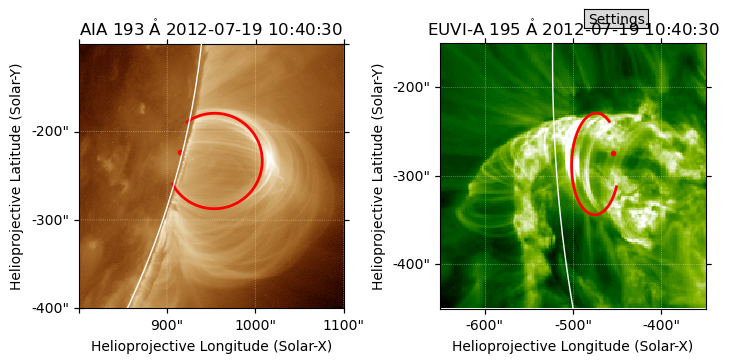

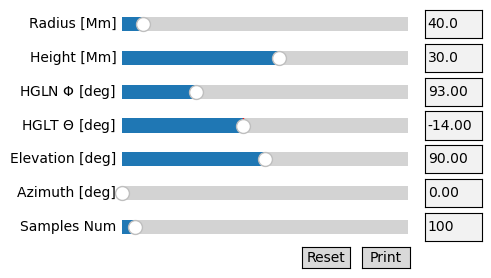

In [33]:
# CLB demo
# Allow interactible sliders in window
if sliders:
    %matplotlib widget
if inline:
    %matplotlib inline

# Create figure with subplots
fig = plt.figure()
subfigs = fig.subfigures(1, 2, wspace=0.3)

# Plot AIA map in the first subplot
ax1 = subfigs[0].add_subplot(projection=aia_map)
aia_map.plot(axes=ax1)
ax1.set_xlim(aia_lims_xpix)
ax1.set_ylim(aia_lims_ypix)
aia_map.draw_limb(axes=ax1)
# aist.plot_ribbon(ax1, matching_pairs, p=p, instr='AIA', cl=aia_crop_lims)


# Plot SDO map in the second subplot
ax2 = subfigs[1].add_subplot(projection=stereo_map)
stereo_map.plot(axes=ax2)
ax2.set_xlim(stereo_lims_xpix)
ax2.set_ylim(stereo_lims_ypix)
aia_map.draw_limb(axes=ax2)
# los = aist.plot_aia_los(ax2, aia_map, loop_params)
# aist.plot_ribbon(ax2, matching_pairs, p=p, instr='STEREO', cl=stereo_crop_lims)

# Adjust layout
plt.tight_layout()

# Save the figure (optional)
directory_path = 'export/'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
plt.savefig(f'{directory_path}aia_stereo_comparison.png')

# Overplot CLB loops
coronal_loop1 = CoronalLoopBuilder(fig, [ax1, ax2], [m, stereo_map], ellipse=ellipse, **loop_params, color=c)


In [34]:
# Optional save CLB parameters if adjusted above
if update_loop:
    coronal_loop1.save_params_to_pickle('AIA_STEREO_195_circular_back.pkl')


# Synthetic projections using AIA / STEREO maps

Use AIA / STEREO images collected above to generate loop-centric synthetic intensity projections from the perspective of the instrument.

In [35]:
# Remaining variables for sfi generation 
datacube = config.SIMULATIONS['DATASET']    # Path to 3D gaseous dataset to be projected
zoom = 0.4                                  # Zoom amount for projected box (0-1)


Compare synthetic projection maps (left) to observational inputs (right) with coronal loops overplotted

Loop length: 192.93821549319134 Mm
Loop length: 192.93821549319134 Mm
Loop length: 192.93821549319134 Mm


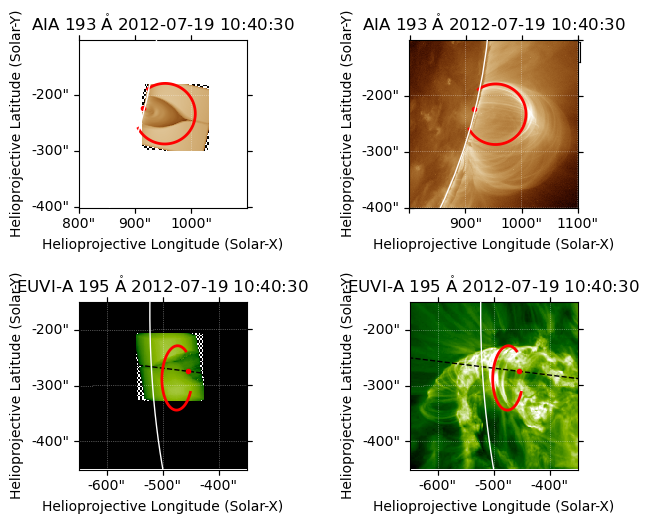

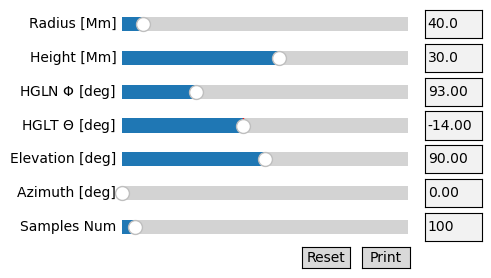

In [36]:
# Comparison plot

# Allow interactible sliders in window
if sliders:
    %matplotlib widget
if inline:
    %matplotlib inline

# Create figure with subplots
fig = plt.figure()
subfigs = fig.subfigures(2, 2, wspace=0.07)

# params = man_loop_params if manual_params else loop_params

# Generate aia-based SFI and plot synthetic, real maps
sfiObj1 = sfi(dataset=datacube, smap=aia_map, pkl=loop_params, zoom=zoom)   #TODO add in manual norm / north to call
ax1, synthmap1, norm1, north1, image_shift1 = sfiObj1.synthmap_plot(fig=subfigs[0,0], plot='synth')
ax2 = subfigs[0,1].add_subplot(projection=aia_map)
aia_map.plot(axes=ax2)
aia_map.draw_limb(axes=ax1)
aia_map.draw_limb(axes=ax2)
ax1.set_xlim(aia_lims_xpix)
ax1.set_ylim(aia_lims_ypix)
ax2.set_xlim(aia_lims_xpix)
ax2.set_ylim(aia_lims_ypix)

# Generate stereo-based SFI and plot synthetic, real maps
sfiObj2 = sfi(dataset=datacube, smap=stereo_map, pkl=loop_params, zoom=zoom)
ax3, synthmap2, norm2, north2, image_shift2 = sfiObj2.synthmap_plot(fig=subfigs[1,0], plot='synth')
ax4 = subfigs[1,1].add_subplot(projection=stereo_map)
stereo_map.plot(axes=ax4)
aia_map.draw_limb(axes=ax3)
aia_map.draw_limb(axes=ax4)
aist.plot_aia_los(ax3, aia_map, loop_params=loop_params)
aist.plot_aia_los(ax4, aia_map, loop_params=loop_params)
ax3.set_xlim(stereo_lims_xpix)
ax3.set_ylim(stereo_lims_ypix)
ax4.set_xlim(stereo_lims_xpix)
ax4.set_ylim(stereo_lims_ypix)

# Overplot CLB loops
coronal_loop1 = CoronalLoopBuilder(fig, [ax1, ax2, ax3, ax4], [synthmap1, aia_map, synthmap2, stereo_map], ellipse=ellipse, **loop_params, color=c)


Optional - save loop and map information to nested dictionary structure, or can update existing nested dictionary structure.

Loop length: 192.93821549319134 Mm


/tmp/ipykernel_18516/722426466.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=6.0)


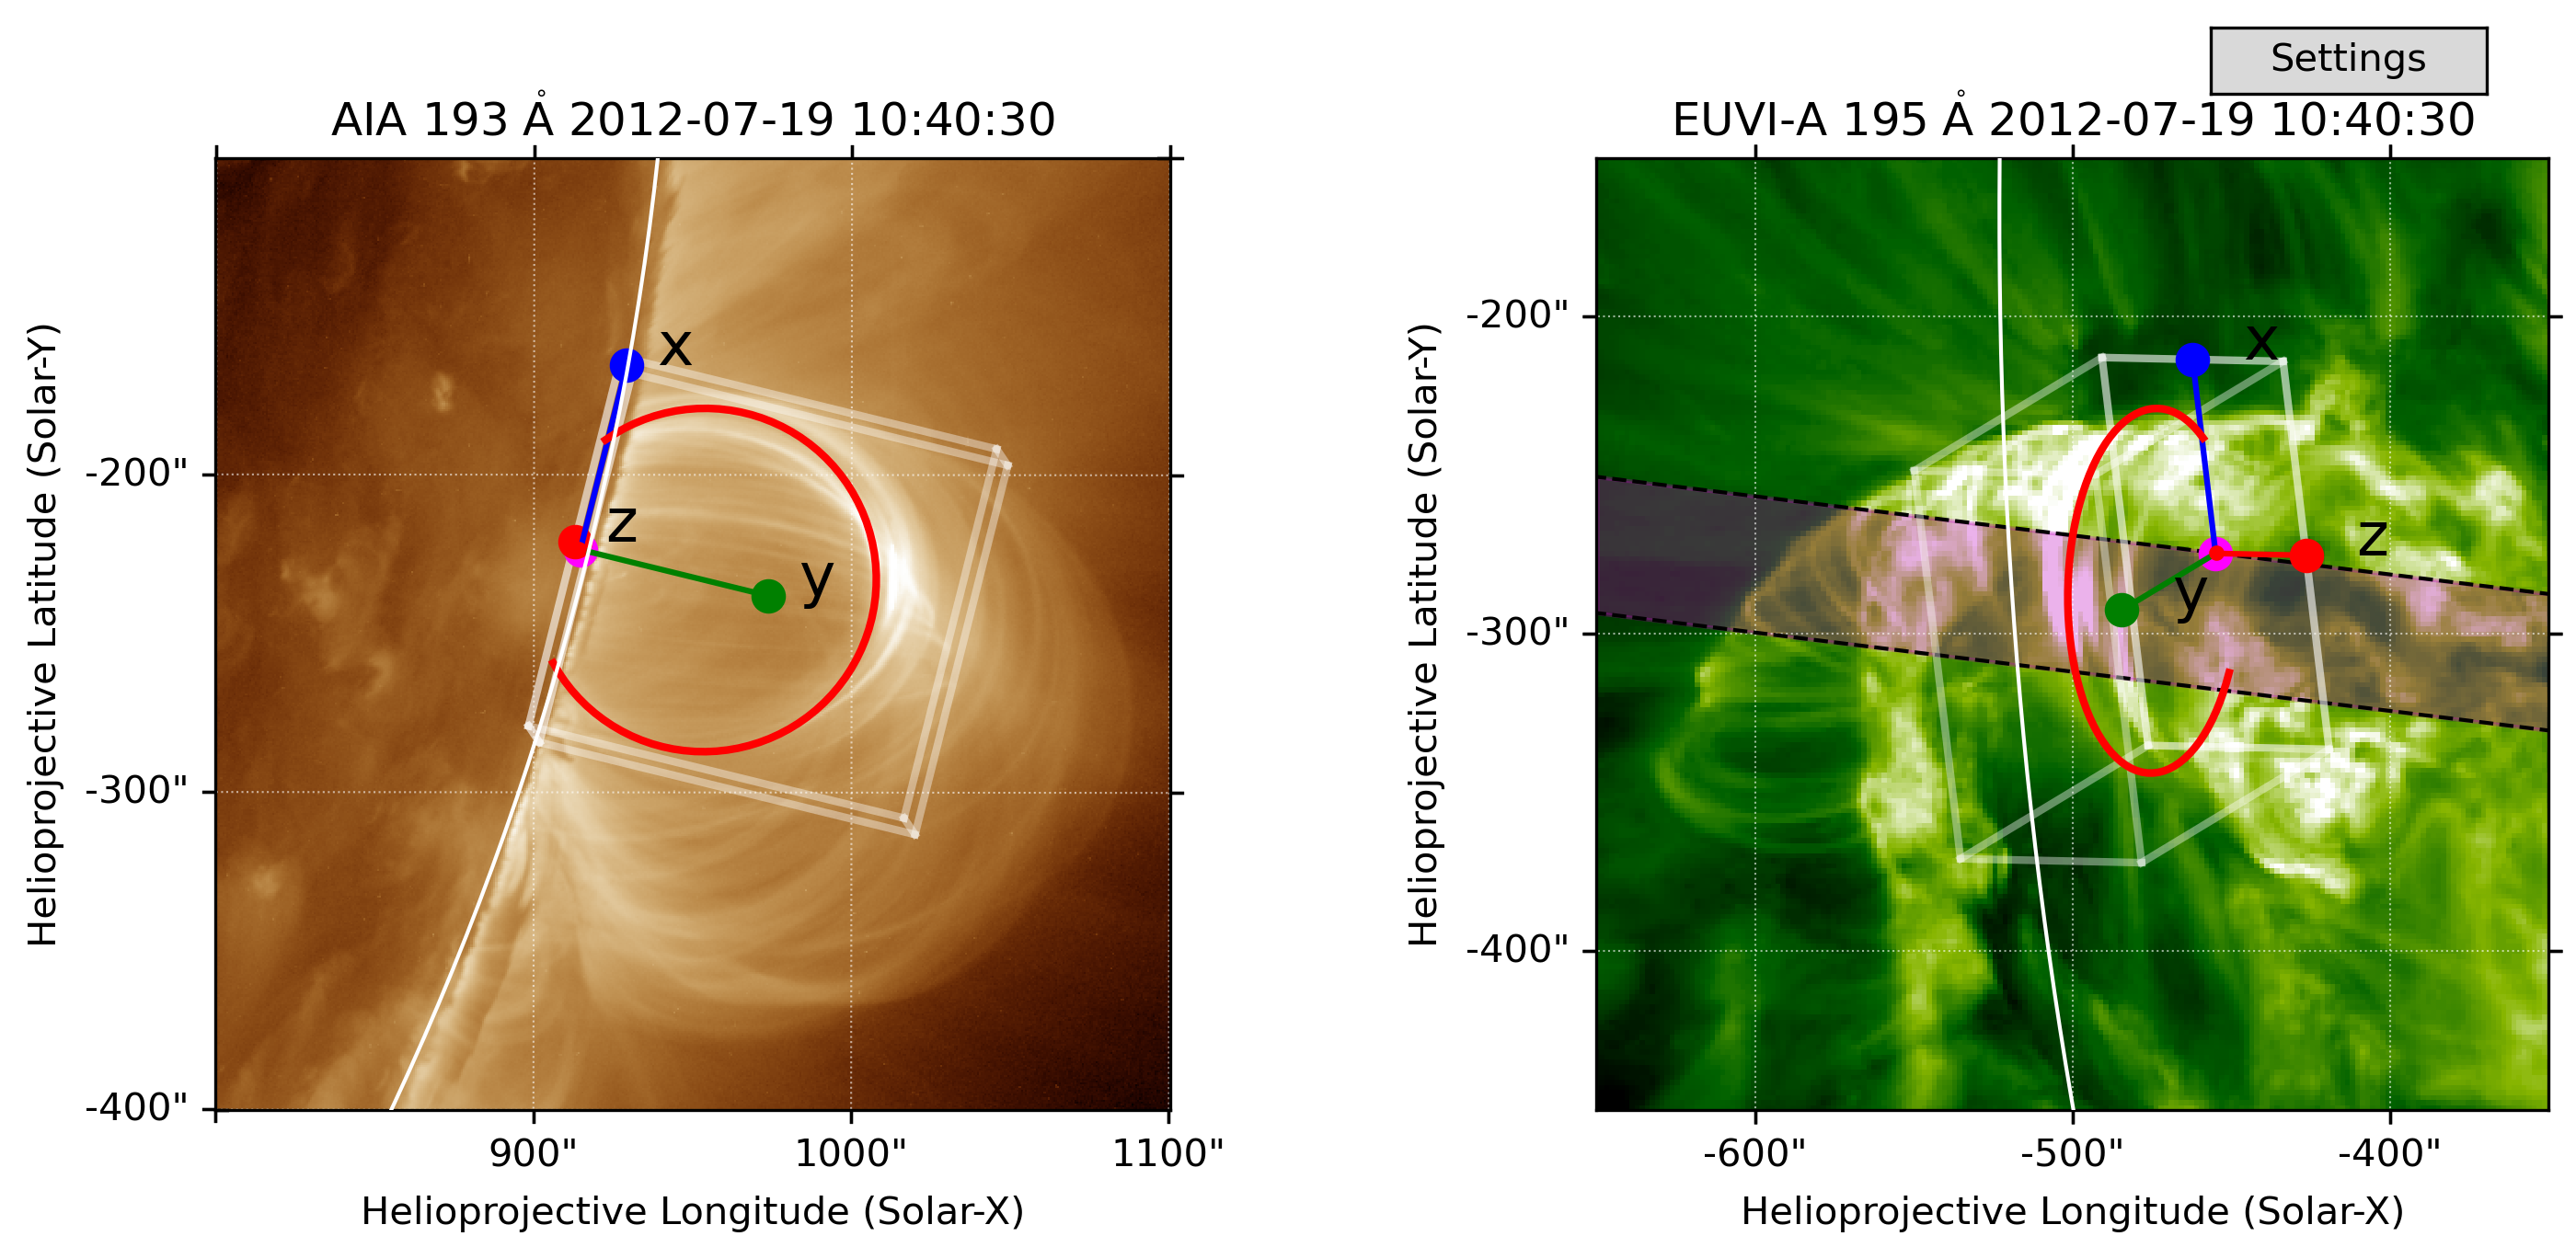

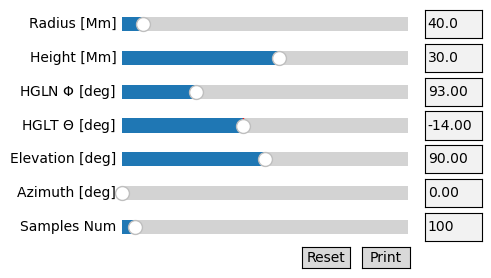

In [37]:
# Allow interactible sliders in window
if sliders:
    %matplotlib widget
if inline:
    %matplotlib inline

# Create figure with subplots
fig = plt.figure(figsize=(10,6), dpi=300)
subfigs = fig.subfigures(1, 2)

# Plot AIA map in the first subplot
ax1 = subfigs[0].add_subplot(projection=aia_map)
aia_map.plot(axes=ax1)
ax1.set_xlim(aia_lims_xpix)
ax1.set_ylim(aia_lims_ypix)
aia_map.draw_limb(axes=ax1)
# plot_ribbon(ax1, matching_pairs, p=p, instr='AIA')
aist.plot_edges(ax1, aia_map, sfiObj1, axes=True, xoffset=16, fontsize=16)

# Plot SDO map in the second subplot
ax2 = subfigs[1].add_subplot(projection=stereo_map)
stereo_map.plot(axes=ax2)
ax2.set_xlim(stereo_lims_xpix)
ax2.set_ylim(stereo_lims_ypix)
aia_map.draw_limb(axes=ax2)
los_b = aist.plot_aia_los(ax2, aia_map, loop_params=loop_params, target='bottom')
los_t = aist.plot_aia_los(ax2, aia_map, loop_params=loop_params, target='top', sfiObj=sfiObj2)
aist.color_slice(ax2, stereo_map, los_b, los_t, color='m', alpha=0.3)

# plot_ribbon(ax2, matching_pairs, p=p, instr='STEREO')
aist.plot_edges(ax2, stereo_map, sfiObj2, axes=True)

# Overplot CLB loops
coronal_loop1 = CoronalLoopBuilder(fig, [ax1, ax2], [m, stereo_map], ellipse=ellipse, **loop_params, color=c)

fig.tight_layout(pad=6.0)
fig.savefig('/home/gabriel/Desktop/boxfig.png')


In [38]:
# Toggle save on or off
if save_synthobj:
    # Update or create new file
    if nested_params:
        updated_synthobj1, loop_path1 = sfiObj1.append_synthobj(PARAMS_PATH)
        updated_synthobj2, loop_path2 = sfiObj2.append_synthobj(PARAMS_PATH)
    else:
        updated_synthobj1, loop_path1 = sfiObj1.append_synthobj()
        updated_synthobj2, loop_path2 = sfiObj2.append_synthobj(loop_path1)

    # Check if new / updated dictionary is correct
    loop_params_dict = aist.extract_loop_params(loop_path1)
    print(loop_path1)
    print(loop_params_dict.keys())


Compare composite real / synthetic maps from AIA and STEREO with overplotted CLB loops

Loop length: 192.93821549319134 Mm


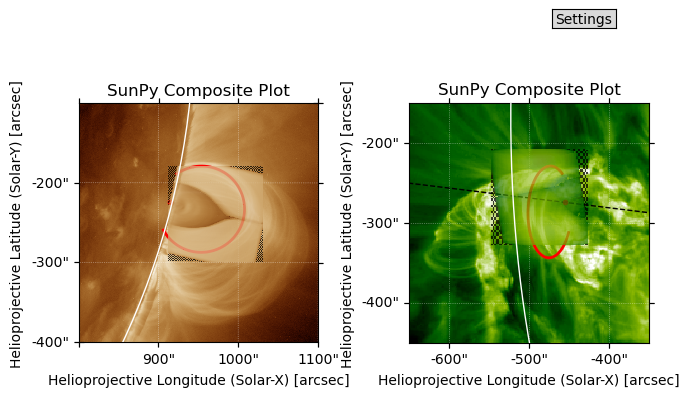

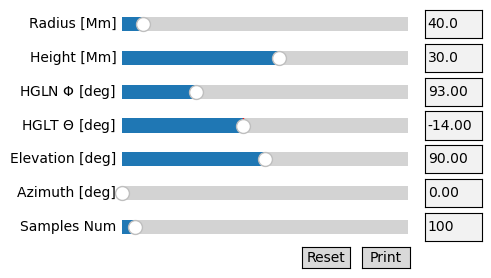

In [39]:
# Composite Plot

# Allow interactible sliders in window
if sliders:
    %matplotlib widget
if inline:
    %matplotlib inline

# Create figure with subplots
fig = plt.figure()
subfigs = fig.subfigures(1, 2, wspace=0.07)

# Generate aia-based SFI and plot composite real-synth map
ax1, synthmap1, norm, north, image_shift = sfiObj1.synthmap_plot(fig=subfigs[0], plot='comp', alpha = 0.75)
aia_map.draw_limb(axes=ax1)
# Generate stereo-based SFI and plot composite real-synth map
ax2, synthmap2, norm, north, image_shift = sfiObj2.synthmap_plot(fig=subfigs[1], plot='comp', alpha = 0.75)
aia_map.draw_limb(axes=ax2)
aist.plot_aia_los(ax2, aia_map, loop_params=loop_params)
ax1.set_xlim(aia_lims_xpix)
ax1.set_ylim(aia_lims_ypix)
ax2.set_xlim(stereo_lims_xpix)
ax2.set_ylim(stereo_lims_ypix)

# Overplot CLB loops
coronal_loop1 = CoronalLoopBuilder(fig, [ax1, ax2], [synthmap1, synthmap2], ellipse=ellipse, **loop_params, color=c)